In [1]:
# Import the relevant Packages

import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.decomposition import PCA

from keras.utils import np_utils



from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
# Create the empty images array
images = [None for i in xrange(numImages)]
# Find and load all the images relevant to the leaves 
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName))
# Make sure the numpy array is an array
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values

# Load the training data from the trawled data
labels=train_labels.tolist()
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)

# Load the test data from the trawled data
test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

# Delete the physical array of loaded images
del images

In [1]:
#CNN train data

# Define the image normalization
def img_norm(img):
    t= 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]
    return t

# Define a function which loads data in batches
def minibatchData(data,labels_encoded,img_size,channel_num=3,batch_num=30):
    images=[]
    for img in data:
        images.append(np.transpose(img_norm(cv2.resize(img,img_size)),[2,0,1]))
    
    
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(images))
        print(batch_num)
        
        for i in range(int(len(images) / batch_num)):
            minibatch_d = images[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num,img_size[0],img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            if labels_encoded is not None:
                minibatch_l = labels_encoded[i*batch_num: (i+1)*batch_num]
                batch_labels.append(torch.LongTensor(minibatch_l))
            else:
                minibatch_l = np.zeros(batch_num)
                batch_labels.append(torch.LongTensor(minibatch_l))
        #data, labels = batch_data, batch_labels 
        
    return zip(batch_data, batch_labels)

In [4]:
# Encode the labels for preprocessing

le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)
Y_labels = np_utils.to_categorical(train_labels_encoded,99)

In [5]:
# Create the minibatch dataset based on the train images

img_size=(224,224)
cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size))
#plt.imshow(cnn_train_data[0][0][3][0])

990
30


594
2


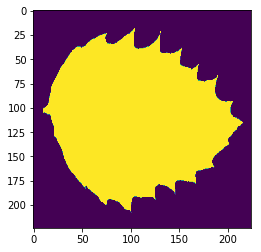

In [6]:
# Test the minibatch with different paramters

cnn_test_data = list(minibatchData(test_images,None,img_size,batch_num=2))
#print cnn_train_data.size
plt.imshow(cnn_test_data[0][0][1][0])

In [7]:
# Load the tuned alex-network into the RAM directly from the pickled instance

filename='tunedAlex.sav'
model_ft = pickle.load(open(filename,'rb'))

In [8]:
# Create the input space / labels for the CNN

probs_cnn_train=np.empty([0,99])
#sm = torch.nn.Softmax()
for data in cnn_train_data:
    images,labels=data
    probs_cnn_train=np.append(probs_cnn_train,(model_ft(images)).data.numpy(),axis=0)
print probs_cnn_train.shape
    

(990, 99)


In [9]:
# Create the input space for the testing of the CNN

probs_cnn_test=np.empty([0,99])
for data in cnn_test_data:
    images, labels = data
    probs_cnn_test=np.append(probs_cnn_test,(model_ft(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print probs_cnn_test.shape

#sm = torch.nn.Softmax()
#probabilities = sm(output) 
#print(probabilities)

(594, 99)


In [10]:
#separate the 3 histograms given to us in the data for training

train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

pca_shape = PCA(n_components=0.99, whiten=True)
pca_shape = pca_shape.fit(train_shape_data)

train_shape_data = pca_shape.transform(train_shape_data)
train_shape_data.shape

(990, 10)

In [11]:
# Separate the 3 histograms iven to us in the data for testing

test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values


test_shape_data = pca_shape.transform(test_shape_data)
test_shape_data.shape
#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

(594, 10)

In [12]:
# Create the BagOfWords SIFT Descriptors

def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

In [13]:
# Create and run the vocabulary for testing/training images

des_start_time =time.time()
des_list_train = get_descriptor(train_images)

des_list_test = get_descriptor(test_images)
des_end_time =time.time()
print "Descriptors computed in {:2f} seconds".format(des_end_time-des_start_time)

Descriptors computed in 139.248525 seconds


In [14]:
# Get the clusters for the BagOfWords

clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 3.207614 seconds


In [15]:
# Get the vocabulary for each feature for the test/train space

vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

print vocab_train.shape

(990, 149)


In [16]:
# Perform PCA on the vocabulary

pca_vocab = PCA(n_components=0.99, whiten=True)
pca_vocab.fit(vocab_train)
vocab_train = pca_vocab.transform(vocab_train)
vocab_test = pca_vocab.transform(vocab_test)

In [34]:
# Input the packages for KERAS

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils import np_utils
import keras

In [35]:
# Define the weak learner networks for each of the logical partitions of data

deep_shape = Sequential([Dense(64, activation='relu'), Dropout(0.7), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_texture = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dropout(0.5), Dense(99, activation='softmax')])
deep_margin = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_sift = Sequential([Dense(128, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dropout(0.5), Dense(99, activation='softmax')])
deep_alex = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dropout(0.5), Dense(99, activation='softmax')])

In [36]:
# Compile the weak learner networks

deep_shape.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_texture.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_margin.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_sift.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_alex.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])

In [37]:
# Perform training on each of the weak learners with hypter parameters that benefit the most

# Loss 2
deep_sift.fit(vocab_train,Y_labels,batch_size=16,epochs=15, validation_split=0.2)
# Loss 2.0 PCA 10 Values
deep_shape.fit(train_shape_data,Y_labels,batch_size=5,epochs=40, validation_split=0.2)
# Loss .80
deep_margin.fit(train_margin_data,Y_labels,batch_size=20,epochs=150, validation_split=0.2)
# Loss .22
deep_alex.fit(probs_cnn_train,Y_labels,batch_size=16,epochs=150, validation_split=0.2)
# Loss 1.3
deep_texture.fit(train_texture_data,Y_labels,batch_size=16,epochs=50, validation_split=0.2)

Train on 792 samples, validate on 198 samples
Epoch 1/15
792/792 [==============================] - 2s 2ms/step - loss: 5.0431 - val_loss: 4.6459
Epoch 2/15
792/792 [==============================] - 0s 302us/step - loss: 4.5984 - val_loss: 4.5855
Epoch 3/15
792/792 [==============================] - 0s 322us/step - loss: 4.4754 - val_loss: 4.5383
Epoch 4/15
792/792 [==============================] - 0s 304us/step - loss: 4.3096 - val_loss: 4.4851
Epoch 5/15
792/792 [==============================] - 0s 395us/step - loss: 4.1779 - val_loss: 4.4145
Epoch 6/15
792/792 [==============================] - 0s 316us/step - loss: 3.9534 - val_loss: 4.3246
Epoch 7/15
792/792 [==============================] - 0s 298us/step - loss: 3.8303 - val_loss: 4.1984
Epoch 8/15
792/792 [==============================] - 0s 302us/step - loss: 3.5194 - val_loss: 4.0365
Epoch 9/15
792/792 [==============================] - 0s 324us/step - loss: 3.3264 - val_loss: 3.8740
Epoch 10/15
792/792 [=================

Epoch 103/150
792/792 [==============================] - 0s 400us/step - loss: 0.7185 - val_loss: 0.8835
Epoch 104/150
792/792 [==============================] - 0s 532us/step - loss: 0.7044 - val_loss: 0.8620
Epoch 105/150
792/792 [==============================] - 0s 493us/step - loss: 0.7187 - val_loss: 0.8576
Epoch 106/150
792/792 [==============================] - 0s 557us/step - loss: 0.7470 - val_loss: 0.8679
Epoch 107/150
792/792 [==============================] - 0s 420us/step - loss: 0.7053 - val_loss: 0.9281
Epoch 108/150
792/792 [==============================] - 0s 389us/step - loss: 0.6839 - val_loss: 0.9067
Epoch 109/150
792/792 [==============================] - 0s 513us/step - loss: 0.7549 - val_loss: 0.8948
Epoch 110/150
792/792 [==============================] - 0s 479us/step - loss: 0.6827 - val_loss: 0.8965
Epoch 111/150
792/792 [==============================] - 0s 458us/step - loss: 0.7054 - val_loss: 0.8807
Epoch 112/150
792/792 [==============================] 

Epoch 31/150
792/792 [==============================] - 0s 429us/step - loss: 0.6028 - val_loss: 0.2793
Epoch 32/150
792/792 [==============================] - 0s 374us/step - loss: 0.5896 - val_loss: 0.2724
Epoch 33/150
792/792 [==============================] - 0s 357us/step - loss: 0.5636 - val_loss: 0.2920
Epoch 34/150
792/792 [==============================] - 0s 415us/step - loss: 0.4631 - val_loss: 0.3299
Epoch 35/150
792/792 [==============================] - 0s 445us/step - loss: 0.5441 - val_loss: 0.2551
Epoch 36/150
792/792 [==============================] - 0s 425us/step - loss: 0.5236 - val_loss: 0.2594
Epoch 37/150
792/792 [==============================] - 0s 389us/step - loss: 0.5263 - val_loss: 0.2960
Epoch 38/150
792/792 [==============================] - 0s 364us/step - loss: 0.5227 - val_loss: 0.3173
Epoch 39/150
792/792 [==============================] - 0s 423us/step - loss: 0.4594 - val_loss: 0.3326
Epoch 40/150
792/792 [==============================] - 0s 406us

792/792 [==============================] - 0s 347us/step - loss: 1.5371 - val_loss: 1.5339
Epoch 38/50
792/792 [==============================] - 0s 339us/step - loss: 1.5356 - val_loss: 1.5363
Epoch 39/50
792/792 [==============================] - 0s 336us/step - loss: 1.4742 - val_loss: 1.4914
Epoch 40/50
792/792 [==============================] - 0s 338us/step - loss: 1.4996 - val_loss: 1.5008
Epoch 41/50
792/792 [==============================] - 0s 334us/step - loss: 1.4486 - val_loss: 1.4839
Epoch 42/50
792/792 [==============================] - 0s 336us/step - loss: 1.4188 - val_loss: 1.4933
Epoch 43/50
792/792 [==============================] - 0s 334us/step - loss: 1.3924 - val_loss: 1.4673
Epoch 44/50
792/792 [==============================] - 0s 334us/step - loss: 1.4340 - val_loss: 1.4546
Epoch 45/50
792/792 [==============================] - 0s 336us/step - loss: 1.3531 - val_loss: 1.4535
Epoch 46/50
792/792 [==============================] - 0s 334us/step - loss: 1.3322 -

In [45]:
# Build the input space for the test data

deep_input = np.array(deep_shape.predict(train_shape_data))
deep_input = np.array(np.append(deep_input, deep_texture.predict(train_texture_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_margin.predict(train_margin_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_sift.predict(vocab_train), axis=1))
deep_input = np.array(np.append(deep_input, deep_alex.predict(probs_cnn_train), axis=1))


# print(deep_input.shape)
# pca_deep = PCA(n_components=0.999, whiten=True)
# pca_deep.fit(deep_input)
# deep_input = pca_deep.transform(deep_input)
# print(deep_input.shape)

# deep_final.fit(deep_input,Y_labels,batch_size=16,epochs=50)

In [46]:
# deep_model = Sequential([
#     Dense(512, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dropout(0.4),
#     Dense(256, activation='relu'),
#     Dense(99, activation='softmax')
# ])

# Setup the model for the deep network

deep_model = Sequential([
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(99, activation='softmax')
])

deep_model.compile(loss='categorical_crossentropy',optimizer='adam',metric=[keras.metrics.categorical_accuracy])

In [47]:
# deep_input=np.array(np.append(train_margin_data,train_texture_data,axis=1))
# deep_input=np.array(np.append(deep_input,train_shape_data,axis=1))
# deep_input=np.array(np.append(deep_input,vocab_train,axis=1))
# deep_input=np.array(np.append(deep_input,probs_cnn_train,axis=1))
# Y_labels = np_utils.to_categorical(train_labels_encoded,99)
# print deep_input.shape

In [48]:
# Fit the deep model on th einput space

deep_model.fit(deep_input,Y_labels,batch_size=5,epochs=10, validation_split=0.3)
deep_model.summary()

Train on 693 samples, validate on 297 samples
Epoch 1/10
693/693 [==============================] - 6s 9ms/step - loss: 4.4789 - val_loss: 4.2671
Epoch 2/10
693/693 [==============================] - 4s 6ms/step - loss: 2.9144 - val_loss: 1.9793
Epoch 3/10
693/693 [==============================] - 4s 6ms/step - loss: 0.8129 - val_loss: 0.4913
Epoch 4/10
693/693 [==============================] - 4s 6ms/step - loss: 0.2630 - val_loss: 0.1719
Epoch 5/10
693/693 [==============================] - 4s 6ms/step - loss: 0.1378 - val_loss: 0.0769
Epoch 6/10
693/693 [==============================] - 4s 6ms/step - loss: 0.0852 - val_loss: 0.0418
Epoch 7/10
693/693 [==============================] - 4s 6ms/step - loss: 0.0601 - val_loss: 0.0472
Epoch 8/10
693/693 [==============================] - 4s 6ms/step - loss: 0.0377 - val_loss: 0.0434
Epoch 9/10
693/693 [==============================] - 4s 6ms/step - loss: 0.0263 - val_loss: 0.0383
Epoch 10/10
693/693 [==============================] -

In [49]:
# deep_input = np.array(deep_shape.predict(train_shape_data))
# deep_input = np.array(np.append(deep_input, deep_texture.predict(train_texture_data), axis=1))
# deep_input = np.array(np.append(deep_input, deep_margin.predict(train_margin_data), axis=1))
# deep_input = np.array(np.append(deep_input, deep_sift.predict(vocab_train), axis=1))
# deep_input = np.array(np.append(deep_input, deep_alex.predict(probs_cnn_train), axis=1))




In [50]:
# Build the test input space for the deep network

deep_input_test = np.array(deep_shape.predict(test_shape_data))
deep_input_test = np.array(np.append(deep_input_test, deep_texture.predict(test_texture_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_margin.predict(test_margin_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_sift.predict(vocab_test), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_alex.predict(probs_cnn_test), axis=1))


out_file = deep_model.predict(deep_input_test)
out_file = np.append(np.array(test_ids).reshape(-1,1),out_file,axis=1)

In [51]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/15_12_18_003(ALexNet15Deep).csv')

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
